In [2]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import zuko
import numpy as np

from itertools import islice
from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

In [3]:
LABELS = ['amp', 'freq', 'tau']
LOWER = torch.tensor([0, 0, 0.001]).cuda()
UPPER = torch.tensor([5, 20, 0.5]).cuda()

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def svd(prior):

    time = np.linspace(-8,8,1000)
    
    #x = torch.stack([amp*torch.sin(freq*time)*torch.exp(-(tau*time)**2)], dim=-1)

    rows = 1000
    x_data = torch.zeros(rows, len(time)).cuda()
    for i in range(rows):
        parameters = prior.sample()
        amp = parameters[...,0]
        freq = parameters[...,1]
        tau = parameters[...,2]

        time_tensor = torch.tensor(time).cuda()
        #x_data = amp * torch.sin(freq * time_tensor) * torch.exp(-(tau * time_tensor)**2).cuda()
        x_j = amp * torch.sin(freq * time_tensor) * torch.exp(-(tau * time_tensor)**2).cuda()
        x_data[i, :] = x_j
    #x = torch.stack(x_data, dim=-1)

    u, s, vh= torch.linalg.svd(x_data, full_matrices=False)
    return u, s, vh, x_data



In [4]:
u, s, vh, x  = svd(prior)

In [5]:
vh.shape, u.shape,s.shape

(torch.Size([1000, 1000]), torch.Size([1000, 1000]), torch.Size([1000]))

In [7]:
s_reduced = s[s>1]
reduced_cols = len(s_reduced)
#reduction = int(s_reduced.shape) 
#print(reduction)
'''s_diag = torch.diag(s_reduced)
print(s_diag)
s_diag.shape'''

's_diag = torch.diag(s_reduced)\nprint(s_diag)\ns_diag.shape'

In [9]:
def model(prior):

    time = np.linspace(-8,8,1000)

    parameters = prior.sample()
    amp = parameters[...,0]
    freq = parameters[...,1]
    tau = parameters[...,2]

    x_data = torch.zeros(len(time)).cuda()
    time_tensor = torch.tensor(time).cuda()
        
    x_data = amp * torch.sin(freq * time_tensor) * torch.exp(-(tau * time_tensor)**2).cuda()
    

    return x_data, time, parameters
    

In [10]:
x_data_test, time_points_test, parameters = model(prior)
#print(x_data_test)
x_data_test.shape

tensor([ 0.1352,  0.2920,  0.4267,  0.5292,  0.5915,  0.6090,  0.5802,  0.5075,
         0.3962,  0.2548,  0.0939, -0.0741, -0.2366, -0.3812, -0.4970, -0.5752,
        -0.6097, -0.5980, -0.5410, -0.4428, -0.3110, -0.1556,  0.0118,  0.1783,
         0.3314,  0.4595,  0.5527,  0.6041,  0.6096,  0.5689,  0.4850,  0.3643,
         0.2159,  0.0510, -0.1179, -0.2778, -0.4168, -0.5243, -0.5920, -0.6148,
        -0.5910, -0.5224, -0.4140, -0.2742, -0.1136,  0.0558,  0.2210,  0.3695,
         0.4901,  0.5736,  0.6135,  0.6070,  0.5544,  0.4597,  0.3300,  0.1753,
         0.0072, -0.1615, -0.3181, -0.4506, -0.5490, -0.6057, -0.6166, -0.5807,
        -0.5007, -0.3827, -0.2355, -0.0705,  0.1000,  0.2630,  0.4061,  0.5184,
         0.5915,  0.6197,  0.6010,  0.5366,  0.4315,  0.2936,  0.1334, -0.0371,
        -0.2048, -0.3570, -0.4822, -0.5709, -0.6163, -0.6150, -0.5670, -0.4760,
        -0.3488, -0.1951, -0.0266,  0.1441,  0.3039,  0.4408,  0.5442,  0.6064,
         0.6226,  0.5916,  0.5157,  0.40

torch.Size([1000])

In [12]:
print(parameters)
parameters.shape

tensor([ 0.6520, 17.2507,  0.0328], device='cuda:0')


torch.Size([3])

In [13]:
v_reduced = vh[:,:reduced_cols]
#projection_matrix = torch.matmul(vh, torch.matmul(torch.inverse(torch.matmul(vh.t(), vh)), vh.t())).double()
#projection = torch.matmul(x_data_test, projection_matrix)

In [19]:
a = projection@v_reduced.double()
a.shape

torch.Size([55])

In [20]:
reconstructed_test_data = a@v_reduced.mH.double()

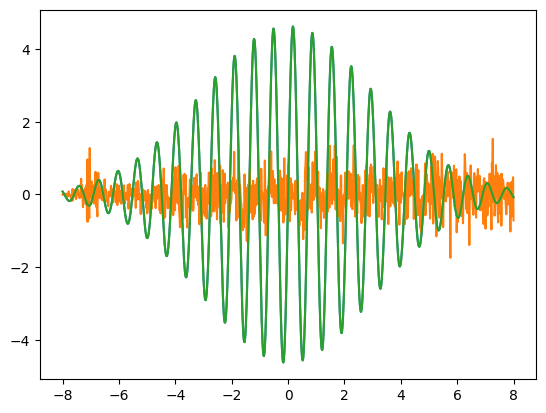

In [28]:
plt.plot(time_points_test, x_data_test.cpu())
plt.plot(time_points_test, reconstructed_test_data.cpu())
plt.plot(time_points_test, projection.cpu())
plt.show()

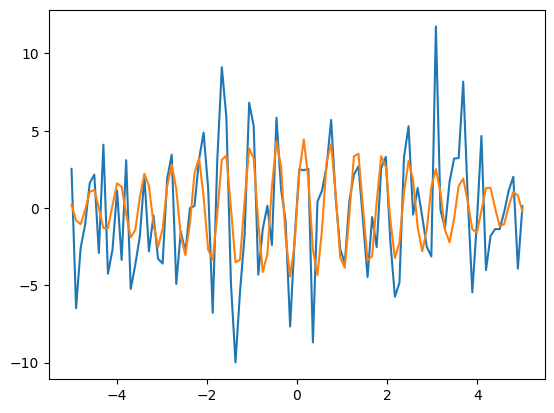

In [ ]:
noisy_data = x_data_test + torch.randn_like(x_data_test)*3
plt.plot(time_points_test, noisy_data.cpu())
plt.plot(time_points_test, x_data_test.cpu())
plt.show()

In [ ]:
help(torch.randn_like)

Help on built-in function randn_like in module torch:

randn_like(...)
    randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) -> Tensor
    
    Returns a tensor with the same size as :attr:`input` that is filled with
    random numbers from a normal distribution with mean 0 and variance 1. Please refer to :func:`torch.randn` for the
    sampling process of complex dtypes. ``torch.randn_like(input)`` is equivalent to
    ``torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)``.
    
    Args:
        input (Tensor): the size of :attr:`input` will determine size of the output tensor.
    
    Keyword args:
        dtype (:class:`torch.dtype`, optional): the desired data type of returned Tensor.
            Default: if ``None``, defaults to the dtype of :attr:`input`.
        layout (:class:`torch.layout`, optional): the desired layout of returned tensor.
            Default: if ``None``, 

In [24]:
x_data_test.shape, v_reduced.shape

(torch.Size([1000]), torch.Size([1000, 55]))

In [23]:
alpha = x_data_test@v_reduced.double()
print(alpha.shape)
print(alpha)

torch.Size([55])
tensor([ 0.0666,  0.6927, -0.1904, -0.4574, -0.6831,  0.1146,  0.3761, -0.6751,
        -0.4290,  0.2484,  0.5097,  0.5694,  0.1303,  0.1779,  0.5692,  0.2164,
        -0.2641, -0.0580,  0.5251, -0.3906,  0.0534, -0.9233,  0.1648, -0.4935,
         0.1299,  0.9035,  0.7123, -0.0945,  0.5127, -0.1497,  0.5235, -0.2436,
        -0.0662, -0.6356,  0.5586, -0.1733,  0.0914, -0.1253, -0.5224,  0.0578,
        -0.0848,  0.2316,  0.3096,  0.0636, -0.5574, -0.0317, -0.1481, -0.0963,
        -0.0146, -0.0087, -0.3399, -0.2653,  0.3521,  0.1675, -0.3350],
       device='cuda:0', dtype=torch.float64)


In [28]:
reconstructed_test_data_1 = alpha@v_reduced.mH.double()

In [29]:
reconstructed_test_data_1-x_data_test

tensor([-1.3495e-01, -2.9640e-01, -4.2165e-01, -5.1770e-01, -5.9169e-01,
        -6.1656e-01, -5.6764e-01, -5.1319e-01, -3.9129e-01, -2.4713e-01,
        -8.0390e-02,  5.6242e-02,  2.2217e-01,  3.8277e-01,  4.8972e-01,
         5.6221e-01,  6.2578e-01,  6.0575e-01,  5.5773e-01,  3.6087e-01,
         2.8124e-01,  1.7520e-01,  2.3834e-02, -1.9281e-01, -3.2578e-01,
        -4.5685e-01, -4.7843e-01, -6.0941e-01, -5.7199e-01, -6.1673e-01,
        -4.9107e-01, -3.9661e-01, -2.2494e-01, -1.3866e-01,  1.5602e-01,
         2.8051e-01,  5.6394e-01,  4.0561e-01,  5.8889e-01,  6.9490e-01,
         5.3842e-01,  4.8806e-01,  4.0420e-01,  2.5531e-01,  1.8704e-01,
         1.3291e-02, -6.2489e-02, -2.4664e-01, -4.6135e-01, -6.0308e-01,
        -4.6724e-01, -7.0379e-01, -6.5593e-01, -6.4928e-02, -8.0143e-01,
         1.3081e-01,  2.9061e-02, -2.0625e-01,  6.4073e-04,  6.2624e-01,
         5.9121e-01,  6.0945e-01,  5.7868e-01,  5.7247e-01,  5.6644e-01,
         4.0431e-01,  2.2707e-01,  8.3582e-02, -8.8

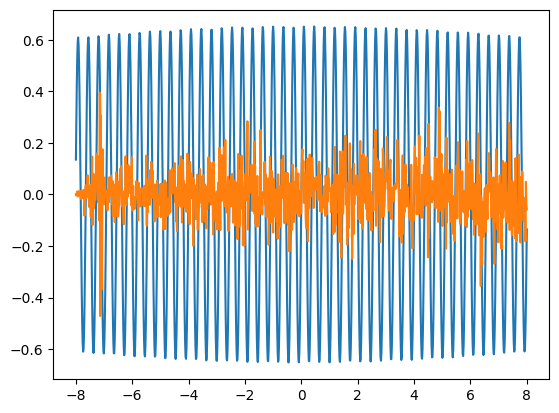

In [31]:
plt.plot(time_points_test, x_data_test.cpu())
plt.plot(time_points_test, reconstructed_test_data_1.cpu())

In [36]:
np.isclose(reconstructed_test_data_1.cpu(), x_data_test.cpu())

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,